<a href="https://colab.research.google.com/github/badhon4772/Computer-Vision-and-Deep-Learning-in-Medical-Imaging/blob/main/Binary%20Classification%20with%20Simple%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import glob
import os

In [ ]:
!pip install split-folders

In [17]:
import splitfolders
import os

input_folder="/content/drive/MyDrive/datasets/ISIC_benign_malignent/dataset"

output="/content/input"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.75, 0.15, 0.10)) ### train 75%, val 15%, test 10%

Copying files: 3297 files [00:54, 60.03 files/s] 


In [5]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [6]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2))) ##output

model.add(layers.Conv2D(64, (3, 3), activation='relu')) ##input
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu')) ##output feature matrix
model.add(layers.Flatten()) #1D feature matrix

model.add(layers.Dense(128, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  #loss='categorical_crossentropy', ### for multi class calsification
  loss='binary_crossentropy', ### for binary calsification
  optimizer=adam,
  metrics=['accuracy']
)

model.optimizer.get_config()
print("\n\n")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,452,801 (9.36 MB)

 Trainable params: 2,452,801 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
### image datagenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/input/train',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle=True)

#steps_per_epoch = training_set.samples // training_set.batch_size


val_set = val_datagen.flow_from_directory('/content/input/val',
                                            target_size = (64,64),
                                            batch_size = 32,
                                            class_mode = 'binary')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('/content/input/test',
                                            target_size = (64,64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 2472 images belonging to 2 classes.
Found 494 images belonging to 2 classes.
Found 331 images belonging to 2 classes.


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

filepath = "/content/CNN.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max')

log_csv = CSVLogger('/content/CNN.csv', separator=',', append=False)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

callbacks_list = [checkpoint1, log_csv, early_stopping]

r = model.fit(
    training_set,
    epochs=100,
    validation_data=val_set,
    callbacks=callbacks_list
)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7832 - loss: 0.4280
Epoch 1: val_accuracy improved from -inf to 0.79757, saving model to /content/CNN.weights.h5
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 362ms/step - accuracy: 0.7831 - loss: 0.4282 - val_accuracy: 0.7976 - val_loss: 0.3886
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7989 - loss: 0.4083
Epoch 2: val_accuracy improved from 0.79757 to 0.82389, saving model to /content/CNN.weights.h5
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 333ms/step - accuracy: 0.7988 - loss: 0.4084 - val_accuracy: 0.8239 - val_loss: 0.3589
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8207 - loss: 0.3954
Epoch 3: val_accuracy did not improve from 0.82389
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 355ms/step - accuracy: 0.8206 - loss: 0.3956 - val_accuracy: 0.8077 - val_loss: 0.3856
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8171 - loss: 0.3889
Epoch 4: val_accuracy did not improve from 0.82389
78/78 ━

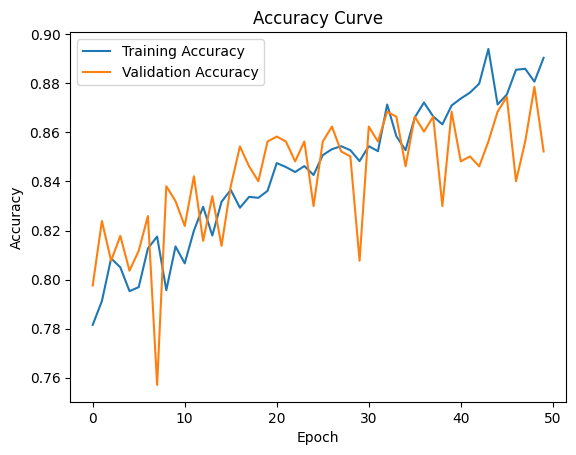

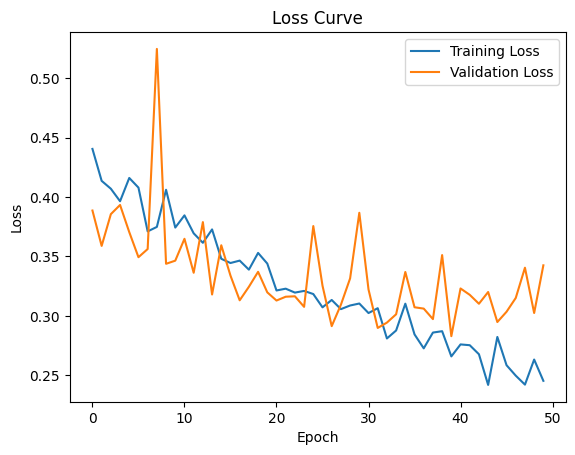

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/CNN.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


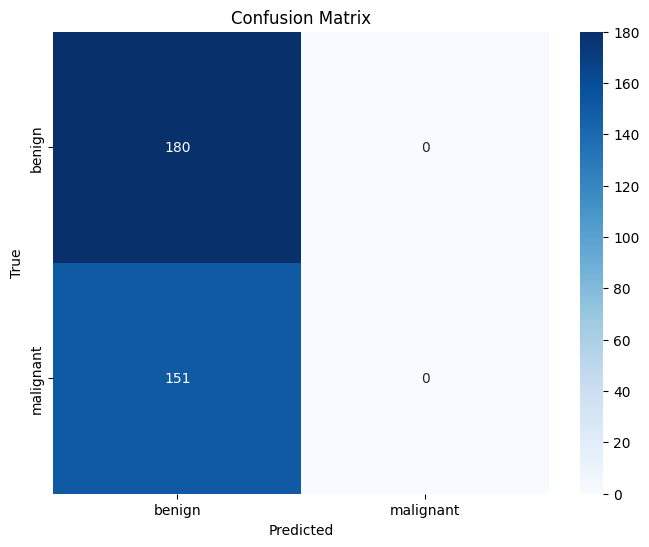

              precision    recall  f1-score   support

      benign       0.54      1.00      0.70       180
   malignant       0.00      0.00      0.00       151

    accuracy                           0.54       331
   macro avg       0.27      0.50      0.35       331
weighted avg       0.30      0.54      0.38       331



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions using the trained model
y_pred = model.predict(test_set)  # Use model.predict instead of model.predict_generator
y_true = test_set.labels  # Ground truth labels

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# You can also generate a classification report for more detailed metrics
class_report = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=test_set.class_indices.keys())
print(class_report)
